In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import geopandas as gpd
import rasterio
import statsmodels.api as sm

from scipy.special import inv_boxcox
from scipy import stats
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

ImportError: Unable to import required dependencies:
numpy: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

In [2]:
# Read in the data
timberDf = pd.read_csv('Data/Annual_USFS_Timber_Harvest.csv')
timberDf.head()

,Region_Code,Region,Clearcut,Prep_Cut,Seed_Cut,Removal_Cut,Selection_Cut,Total_Clearcut_Removal,Total_Clearcut_Removal_Selection,Improvement_Cuts,Commercial_Thin,Sanitation,Special_Cut,Total_All_Harvests,Fiscal_Year
0,"R1,",Northern,3679.0,0.0,3514.0,491.0,7.0,4170.0,4177.0,2645.0,3700.0,945.0,116.0,15098.0,2023.0
1,"R2,",Rocky,5110.0,0.0,3018.0,4846.0,4574.0,9956.0,14530.0,2219.0,2721.0,564.0,374.0,23426.0,2023.0
2,"R3,",Southwestern,0.0,0.0,0.0,0.0,3286.0,0.0,3286.0,3793.0,9628.0,11.0,0.0,16718.0,2023.0
3,"R4,",Intermountain,1217.0,0.0,0.0,588.0,1977.0,1805.0,3782.0,657.0,2664.0,1275.0,0.0,8378.0,2023.0
4,"R5,",Pacific,460.0,0.0,0.0,0.0,1312.0,460.0,1772.0,309.0,8686.0,10912.0,0.0,21680.0,2023.0


In [3]:
timberDf['Region_Code'] = timberDf['Region_Code'].str[:-1]
timberDf

,Region_Code,Region,Clearcut,Prep_Cut,Seed_Cut,Removal_Cut,Selection_Cut,Total_Clearcut_Removal,Total_Clearcut_Removal_Selection,Improvement_Cuts,Commercial_Thin,Sanitation,Special_Cut,Total_All_Harvests,Fiscal_Year
0,R1,Northern,3679.0,0.0,3514.0,491.0,7.0,4170.0,4177.0,2645.0,3700.0,945.0,116.0,15098.0,2023.0
1,R2,Rocky,5110.0,0.0,3018.0,4846.0,4574.0,9956.0,14530.0,2219.0,2721.0,564.0,374.0,23426.0,2023.0
2,R3,Southwestern,0.0,0.0,0.0,0.0,3286.0,0.0,3286.0,3793.0,9628.0,11.0,0.0,16718.0,2023.0
3,R4,Intermountain,1217.0,0.0,0.0,588.0,1977.0,1805.0,3782.0,657.0,2664.0,1275.0,0.0,8378.0,2023.0
4,R5,Pacific,460.0,0.0,0.0,0.0,1312.0,460.0,1772.0,309.0,8686.0,10912.0,0.0,21680.0,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,R5,Pacific,14431.0,1187.0,4739.0,21523.0,9847.0,35954.0,45801.0,0.0,4348.0,64200.0,284.0,120559.0,1984.0
356,R6,Pacific,42545.0,3813.0,14102.0,47767.0,6305.0,90312.0,96617.0,1336.0,7764.0,40664.0,59.0,164355.0,1984.0
357,R8,Southern,106859.0,735.0,5063.0,13639.0,0.0,120498.0,120498.0,0.0,104211.0,28252.0,353.0,259112.0,1984.0
358,R9,Eastern,59440.0,883.0,2744.0,4095.0,7794.0,63535.0,71329.0,2400.0,34524.0,4372.0,0.0,116252.0,1984.0


In [4]:
timberDf['Region'] = np.where(timberDf['Region_Code'] == 'R2', 'Rocky_Mountain',
                              np.where(timberDf['Region_Code'] == 'R5', 'Pacific_Southwest',
                                       np.where(timberDf['Region_Code'] == 'R6', 'Pacific_Northwest', timberDf['Region'])))
timberDf

,Region_Code,Region,Clearcut,Prep_Cut,Seed_Cut,Removal_Cut,Selection_Cut,Total_Clearcut_Removal,Total_Clearcut_Removal_Selection,Improvement_Cuts,Commercial_Thin,Sanitation,Special_Cut,Total_All_Harvests,Fiscal_Year
0,R1,Northern,3679.0,0.0,3514.0,491.0,7.0,4170.0,4177.0,2645.0,3700.0,945.0,116.0,15098.0,2023.0
1,R2,Rocky_Mountain,5110.0,0.0,3018.0,4846.0,4574.0,9956.0,14530.0,2219.0,2721.0,564.0,374.0,23426.0,2023.0
2,R3,Southwestern,0.0,0.0,0.0,0.0,3286.0,0.0,3286.0,3793.0,9628.0,11.0,0.0,16718.0,2023.0
3,R4,Intermountain,1217.0,0.0,0.0,588.0,1977.0,1805.0,3782.0,657.0,2664.0,1275.0,0.0,8378.0,2023.0
4,R5,Pacific_Southwest,460.0,0.0,0.0,0.0,1312.0,460.0,1772.0,309.0,8686.0,10912.0,0.0,21680.0,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,R5,Pacific_Southwest,14431.0,1187.0,4739.0,21523.0,9847.0,35954.0,45801.0,0.0,4348.0,64200.0,284.0,120559.0,1984.0
356,R6,Pacific_Northwest,42545.0,3813.0,14102.0,47767.0,6305.0,90312.0,96617.0,1336.0,7764.0,40664.0,59.0,164355.0,1984.0
357,R8,Southern,106859.0,735.0,5063.0,13639.0,0.0,120498.0,120498.0,0.0,104211.0,28252.0,353.0,259112.0,1984.0
358,R9,Eastern,59440.0,883.0,2744.0,4095.0,7794.0,63535.0,71329.0,2400.0,34524.0,4372.0,0.0,116252.0,1984.0


<Axes: xlabel='Fiscal_Year', ylabel='Total_All_Harvests'>

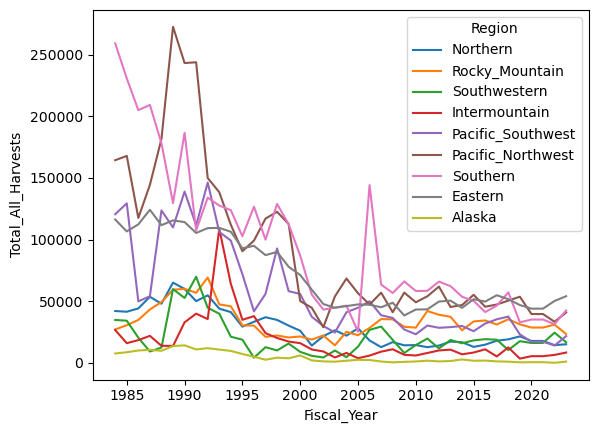

In [5]:
sns.lineplot(timberDf, x='Fiscal_Year', y='Total_All_Harvests', hue='Region')

In [6]:
regionDf = timberDf.groupby(['Region', 'Fiscal_Year']).agg({'Total_All_Harvests': 'sum'}).reset_index()
regionDf = regionDf.sort_values(by=['Total_All_Harvests', 'Fiscal_Year'], ascending=False)
allDf = timberDf.groupby(['Fiscal_Year']).agg({'Total_All_Harvests': 'sum'}).reset_index()
allDf.head()

,Fiscal_Year,Total_All_Harvests
0,1984.0,798478.0
1,1985.0,765379.0
2,1986.0,612658.0
3,1987.0,670320.0
4,1988.0,728424.0


<Axes: xlabel='Region', ylabel='Total_All_Harvests'>

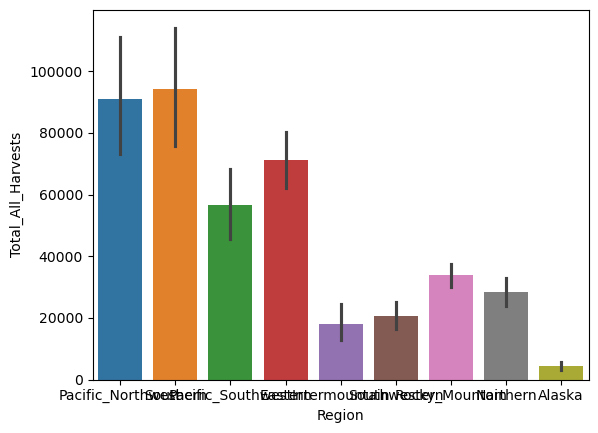

In [7]:
sns.barplot(regionDf, x='Region', y='Total_All_Harvests', hue='Region')

<Axes: xlabel='Fiscal_Year', ylabel='Total_All_Harvests'>

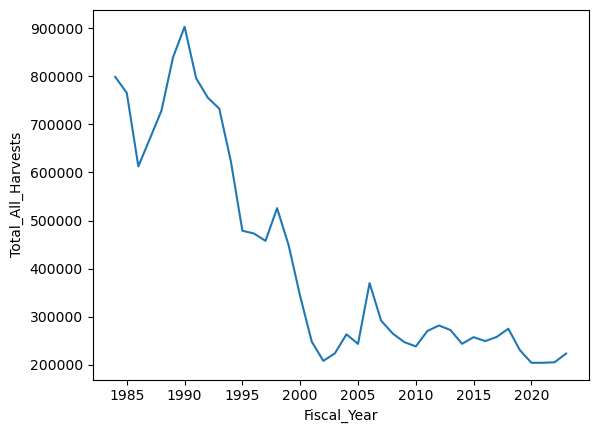

In [8]:
sns.lineplot(allDf, x='Fiscal_Year', y='Total_All_Harvests')

<Axes: >

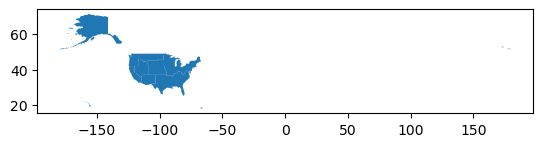

In [9]:
regionsUSFS_shp = gpd.read_file('Shapefiles/S_USA.AdministrativeRegion/S_USA.AdministrativeRegion.shp')
regionsUSFS_shp.plot()

<Axes: >

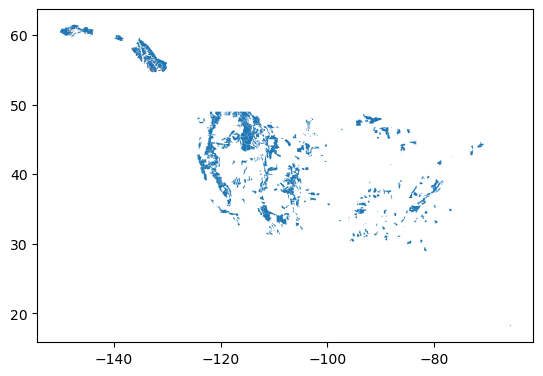

In [10]:
forestsUSFS_shp = gpd.read_file('Shapefiles/S_USA.AdministrativeRegion/S_USA.AdministrativeForest.shp')
forestsUSFS_shp.plot()

In [11]:
regionsUSFS_shp.crs == forestsUSFS_shp.crs

True

In [12]:
nationalIndustryDf = pd.read_csv('Data/Economic_Data/National_Industries_1997.csv')
nationalIndustryDf = nationalIndustryDf.iloc[[4,10,13,60,61]]
nationalIndustryDf = nationalIndustryDf.reset_index(drop=True)
nationalIndustryDf = nationalIndustryDf.iloc[:,1:]
nationalIndustryDf

,Industry,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,"Forestry, fishing, and related activities",38.5,41.9,45.4,39.3,39.0,39.5,41.4,45.4,46.6,...,56.4,54.7,51.1,53.4,53.1,51.0,53.8,61.5,65.5,66.3
1,Construction,709.1,779.6,841.6,913.8,956.8,969.9,1039.4,1158.0,1287.1,...,1264.7,1395.5,1508.6,1578.0,1662.0,1732.2,1809.8,1990.2,2194.5,2335.9
2,Wood products,88.6,91.8,98.1,94.5,87.5,90.0,92.3,105.7,114.6,...,96.7,99.8,103.2,108.5,120.4,112.4,123.5,162.9,174.2,168.7
3,Real estate,1256.1,1327.1,1410.9,1524.2,1622.8,1732.7,1841.9,2022.2,2244.6,...,2876.1,3033.8,3182.2,3298.7,3456.7,3654.8,3755.1,4157.2,4540.6,4897.5
4,Housing,857.9,911.4,968.0,1028.5,1103.7,1148.9,1193.8,1264.8,1355.0,...,1829.1,1885.0,1958.4,2033.6,2116.0,2218.9,2343.4,2477.0,2695.4,2927.3


In [13]:
nationalIndustryDf = pd.melt(nationalIndustryDf, id_vars='Industry',
        value_vars=[str(year) for year in range(1997, 2024)],
        var_name='Fiscal_Year',
        value_name='Revenue')
nationalIndustryDf['Fiscal_Year'] = nationalIndustryDf['Fiscal_Year'].astype(int)

In [14]:
superDf = allDf.merge(
    nationalIndustryDf,
    on='Fiscal_Year',
    how='inner')
superDf

,Fiscal_Year,Total_All_Harvests,Industry,Revenue
0,1997.0,457848.0,"Forestry, fishing, and related activities",38.5
1,1997.0,457848.0,Construction,709.1
2,1997.0,457848.0,Wood products,88.6
3,1997.0,457848.0,Real estate,1256.1
4,1997.0,457848.0,Housing,857.9
...,...,...,...,...
130,2023.0,223753.0,"Forestry, fishing, and related activities",66.3
131,2023.0,223753.0,Construction,2335.9
132,2023.0,223753.0,Wood products,168.7
133,2023.0,223753.0,Real estate,4897.5


In [15]:
superDf = superDf.pivot_table(index=['Fiscal_Year', 'Total_All_Harvests'],
                    columns='Industry',
                    values='Revenue').reset_index()

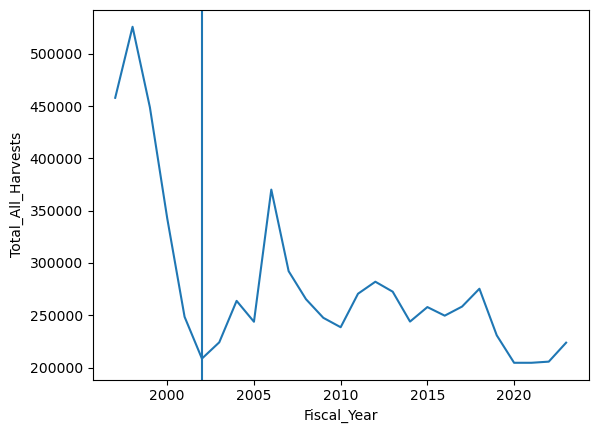

In [85]:
superDf['Fiscal_Year'].unique()

sns.lineplot(superDf, x='Fiscal_Year', y='Total_All_Harvests')
plt.axvline(2002)

In [267]:
superDf = superDf[superDf.Fiscal_Year > 2001]
train = superDf[superDf.Fiscal_Year < 2018]
test = superDf[superDf.Fiscal_Year > 2017]
test

Industry,Fiscal_Year,Total_All_Harvests,Housing,Real estate,Wood products,"Forestry, fishing, and related activities",Construction
21,2018.0,275314.0,2116.0,3456.7,120.4,53.1,1662.0
22,2019.0,230771.0,2218.9,3654.8,112.4,51.0,1732.2
23,2020.0,204527.0,2343.4,3755.1,123.5,53.8,1809.8
24,2021.0,204527.0,2477.0,4157.2,162.9,61.5,1990.2
25,2022.0,205620.0,2695.4,4540.6,174.2,65.5,2194.5
26,2023.0,223753.0,2927.3,4897.5,168.7,66.3,2335.9


In [268]:
X = superDf['Fiscal_Year']
y = superDf['Total_All_Harvests']
lm_1 = sm.OLS(y,X)
result = lm_1.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:     Total_All_Harvests   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              988.9
Date:                Mon, 24 Mar 2025   Prob (F-statistic):                    3.79e-19
Time:                        20:56:40   Log-Likelihood:                         -262.41
No. Observations:                  22   AIC:                                      526.8
Df Residuals:                      21   BIC:                                      527.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

<Axes: xlabel='None', ylabel='None'>

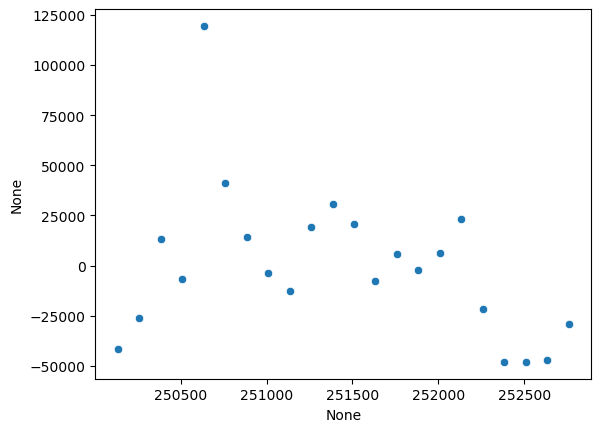

In [269]:
fittedValues = result.fittedvalues
residuals = result.resid

residualDf = (pd.concat([fittedValues,residuals], axis=1)
 .rename(columns={0:'Fitted',1:'Residuals'}))

sns.scatterplot(residualDf, x=fittedValues, y=residuals)

In [270]:
stats.shapiro(residuals)

ShapiroResult(statistic=0.8877768009163034, pvalue=0.017058983400378563)

In [90]:
def box_cox_transformation(x: pd.Series) -> tuple[np.array, float]:
    x_transformed, lambda_value = stats.boxcox(x)
    return x_transformed, lambda_value

def box_cox_inverse_transformation(x: pd.Series, lambda_value: float) -> pd.Series:
    return inv_boxcox(x, lambda_value)

In [271]:
X = sm.add_constant(superDf['Fiscal_Year'])
y_transformed = np.log(superDf['Total_All_Harvests'])
lm_1 = sm.OLS(y_transformed, X)
result = lm_1.fit()

In [77]:
#X = sm.add_constant(superDf['Fiscal_Year'])
#y_transformed, fitted_lambda = box_cox_transformation(superDf['Total_All_Harvests'])
#lm_1 = sm.OLS(y_transformed, X)
#result = lm_1.fit()

<Axes: xlabel='None', ylabel='None'>

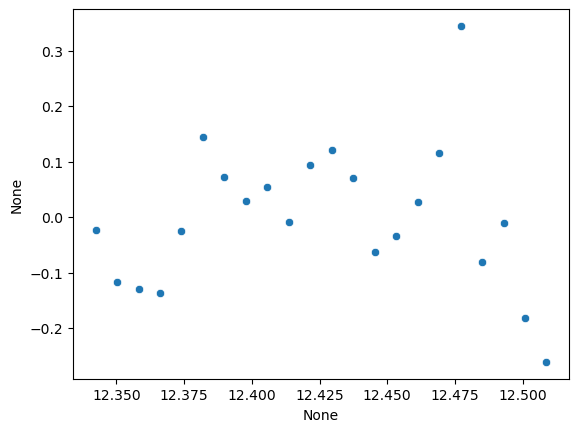

In [272]:
fittedValues = result.fittedvalues
residuals = result.resid

residualDf = (pd.concat([fittedValues,residuals], axis=1)
 .rename(columns={0:'Fitted',1:'Residuals'}))

sns.scatterplot(residualDf, x=fittedValues, y=residuals)

In [273]:
stats.shapiro(residuals)

ShapiroResult(statistic=0.9720826277011279, pvalue=0.7587682285100842)

In [274]:
test.drop(['Total_All_Harvests'], axis=1)

Industry,Fiscal_Year,Housing,Real estate,Wood products,"Forestry, fishing, and related activities",Construction
21,2018.0,2116.0,3456.7,120.4,53.1,1662.0
22,2019.0,2218.9,3654.8,112.4,51.0,1732.2
23,2020.0,2343.4,3755.1,123.5,53.8,1809.8
24,2021.0,2477.0,4157.2,162.9,61.5,1990.2
25,2022.0,2695.4,4540.6,174.2,65.5,2194.5
26,2023.0,2927.3,4897.5,168.7,66.3,2335.9


In [275]:
X_train = train.drop(['Total_All_Harvests'], axis=1)
y_train = train['Total_All_Harvests']
y_train = np.log(y_train)

X_test = test.drop(['Total_All_Harvests'], axis=1)
y_test = test['Total_All_Harvests']
y_test = np.log(y_test)

In [296]:
param_grid = {
    'learning_rate': [0.15, 0.2, 0.3, 0.4],
   'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'subsample': [0.5, 0.6],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'alpha': [0.2, 0.3, 0.4],
    'lambda': [0.8, 1, 1.2]
}

In [297]:
reg = xgb.XGBRegressor(random_state=33, objective='reg:squarederror', eval_metric='rmse', )

In [298]:
xgbModel = GridSearchCV(estimator=reg, param_grid=param_grid)

In [299]:
xgbModel.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=33, ...),
             param_grid={'alpha': [0.2, 0.3, 0.4],
                         'colsample_bytree': [0.5, 0.75, 1.0],
                         'lambda': [0.8, 1, 1.2],
                         'learning_rate': [0.15, 0.2, 0.3, 0.4],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.6]})

In [300]:
best_model = xgbModel.best_estimator_
best_model

XGBRegressor(alpha=0.4, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.2, learning_rate=0.15,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [288]:
y_test

21    12.525668
22    12.349181
23    12.228455
24    12.228455
25    12.233785
26    12.318298
Name: Total_All_Harvests, dtype: float64

In [304]:
X_pred_log = best_model.predict(X_test)
np.exp(X_pred_log)
mean_squared_error(np.exp(y_test), np.exp(X_pred_log))

1894884006.4839332

In [303]:
y_test

21    12.525668
22    12.349181
23    12.228455
24    12.228455
25    12.233785
26    12.318298
Name: Total_All_Harvests, dtype: float64

In [165]:
test

Industry,Fiscal_Year,Total_All_Harvests,Housing,Real estate,Wood products,"Forestry, fishing, and related activities",Construction
21,2018.0,275314.0,2116.0,3456.7,120.4,53.1,1662.0
22,2019.0,230771.0,2218.9,3654.8,112.4,51.0,1732.2
23,2020.0,204527.0,2343.4,3755.1,123.5,53.8,1809.8
24,2021.0,204527.0,2477.0,4157.2,162.9,61.5,1990.2
25,2022.0,205620.0,2695.4,4540.6,174.2,65.5,2194.5
26,2023.0,223753.0,2927.3,4897.5,168.7,66.3,2335.9


In [61]:
X_predict = [2024,2025,2026,2027,2028,2029,2030]
X_predict

[2024, 2025, 2026, 2027, 2028, 2029, 2030]

# YOU SEEING THIS SHIT

In [4]:
quarters = pd.read_csv('/Users/louisgoodall/Desktop/Timber Data.csv')
quarters

,National Forest,Year,Quarter,Product,Species,Sold_Volume_MBF,Sold_Volume_CCF,Sold_Value,Sold_per_MBF,Sold_per_CCF,Cut_Volume_MBF,Cut_Volume_CCF,Cut_Value
0,Deschutes,2010.0,1.0,Sawtimber,Incense cedar,0.0,0.00,0.00,0.00,0.00,12.86,30.00,1203.60
1,Deschutes,2010.0,1.0,Sawtimber,Lodgepole pine,28.9,58.54,1170.80,40.51,20.00,2852.70,5854.11,185347.50
2,Deschutes,2010.0,1.0,Sawtimber,Ponderosa pine,0.0,0.00,0.00,0.00,0.00,2094.39,4378.61,94635.43
3,Deschutes,2010.0,1.0,Sawtimber,White fir,0.0,0.00,0.00,0.00,0.00,492.00,1003.66,27096.37
4,Deschutes,2010.0,1.0,Sawtimber,Western white pine,0.0,0.00,0.00,0.00,0.00,5.01,8.78,195.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,Colville,2010.0,4.0,Non-saw,Miscellaneous,0.0,0.00,0.00,0.00,0.00,780.92,1501.77,375.46
778,Colville,2010.0,4.0,Non-saw,Western Larch,0.0,0.00,0.00,0.00,0.00,127.55,245.28,122.66
779,Colville,2010.0,4.0,Non-saw,Softwood Other,0.0,0.00,0.00,0.00,0.00,1603.01,3057.61,847.89
780,Colville,2010.0,4.0,Non-saw,Hardwood Other,0.0,0.00,0.00,0.00,0.00,2209.89,4249.78,1064.55


In [25]:
quartersWide = quarters.pivot(index=['National Forest','Year','Species','Product'],
                              columns='Quarter', values='Sold_Value').reset_index()
quartersWide = quartersWide.drop(quartersWide.columns[4], axis=1)
quartersWide

Quarter,National Forest,Year,Species,Product,1.0,2.0,3.0,4.0
0,Columbia River Gorge,NaN,Douglas-fir,Sawtimber,NaN,NaN,NaN,NaN
1,Columbia River Gorge,2010.0,Douglas-fir,Fuelwood,189110.25,NaN,NaN,NaN
2,Columbia River Gorge,2010.0,Douglas-fir,Sawtimber,NaN,NaN,107434.39,NaN
3,Columbia River Gorge,2010.0,Douglas-fir,Sawtimber,NaN,107434.39,NaN,NaN
4,Colville,2010.0,Douglas-fir,Non-saw,0.00,701.20,701.20,182606.41
...,...,...,...,...,...,...,...,...
279,Willamette,2010.0,Western Red Cedar,Poles,85.00,85.00,135.00,249.00
280,Willamette,2010.0,Western Red Cedar,Posts,20.00,20.00,120.00,165.00
281,Willamette,2010.0,Western Red Cedar,Sawtimber,503.50,503.50,503.50,503.50
282,Willamette,2010.0,Western White Pine,Sawtimber,0.00,0.00,0.00,0.00


In [36]:
annualDf = pd.read_csv("Data/Annual_Timber_Data.csv")
annualDf = annualDf[['Fiscal Year', 'Price_per_MBF_Harvested']]
annualDf['Price_Log'] = np.log(annualDf['Price_per_MBF_Harvested'])
annualDf['Roll_10'] = annualDf['Price_per_MBF_Harvested'].rolling(window=10, min_periods=1).mean()
train = annualDf[annualDf['Fiscal Year'] < 2002]
test = annualDf[annualDf['Fiscal Year'] >= 2002]

In [37]:
X_test, y_test = test[['Fiscal Year']], test[['Roll_10']]
X_train, y_train = train[['Fiscal Year']], train[['Roll_10']]

In [38]:
annualDf

,Fiscal Year,Price_per_MBF_Harvested,Price_Log,Roll_10
0,1905,1.25,0.223144,1.250000
1,1906,1.47,0.385262,1.360000
2,1907,1.73,0.548121,1.483333
3,1908,2.02,0.703098,1.617500
4,1909,1.92,0.652325,1.678000
...,...,...,...,...
115,2020,54.57,3.999484,60.929000
116,2021,64.10,4.160444,62.041000
117,2022,55.55,4.017284,62.089000
118,2023,55.47,4.015842,61.800000


In [39]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'n_estimators': [100],
#    'max_depth': [2, 3, 4],
#    'subsample': [0.5, 0.6],
#    'colsample_bytree': [0.5, 0.75, 1.0],
#    'alpha': [0.2, 0.3, 0.4],
#    'lambda': [0.8, 1, 1.2]
}

In [40]:
reg = xgb.XGBRegressor(random_state=33, objective='reg:squarederror', eval_metric='rmse')
xgbModel = GridSearchCV(estimator=reg, param_grid=param_grid)
xgbModel.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=33, ...),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01],
                         'n_estimators': [100]})

In [41]:
best_model = xgbModel.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=33, ...)

In [42]:
y_pred = best_model.predict(X_test)
mean_squared_error(y_test, y_pred)

632.1179809570312

In [64]:
arimaDf

,Fiscal Year,Price_per_MBF_Harvested,lag1,roll5,valueDiff
40,1945-01-01,4.14,NaN,NaN,NaN
41,1946-01-01,4.21,4.14,NaN,0.07
42,1947-01-01,4.28,4.21,NaN,0.07
43,1948-01-01,5.60,4.28,NaN,1.32
44,1949-01-01,7.69,5.60,5.184,2.09
...,...,...,...,...,...
115,2020-01-01,54.57,65.23,64.038,-10.66
116,2021-01-01,64.10,54.57,64.050,9.53
117,2022-01-01,55.55,64.10,61.386,-8.55
118,2023-01-01,55.47,55.55,58.984,-0.08


In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox

ADF Statistic: -1.502590187593692
p-value: 0.5322296232075036
ADF Statistic: -6.007474685890925
p-value: 1.602681905981872e-07


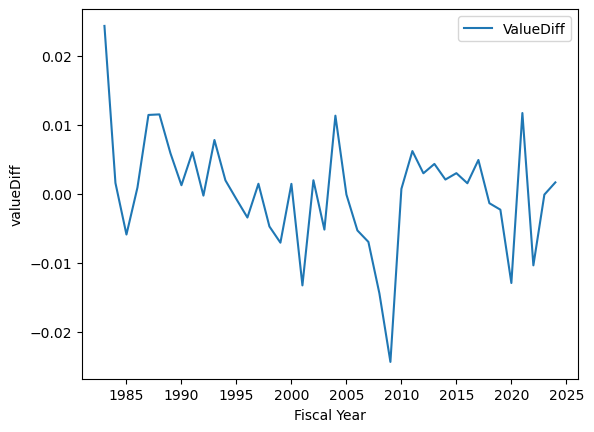

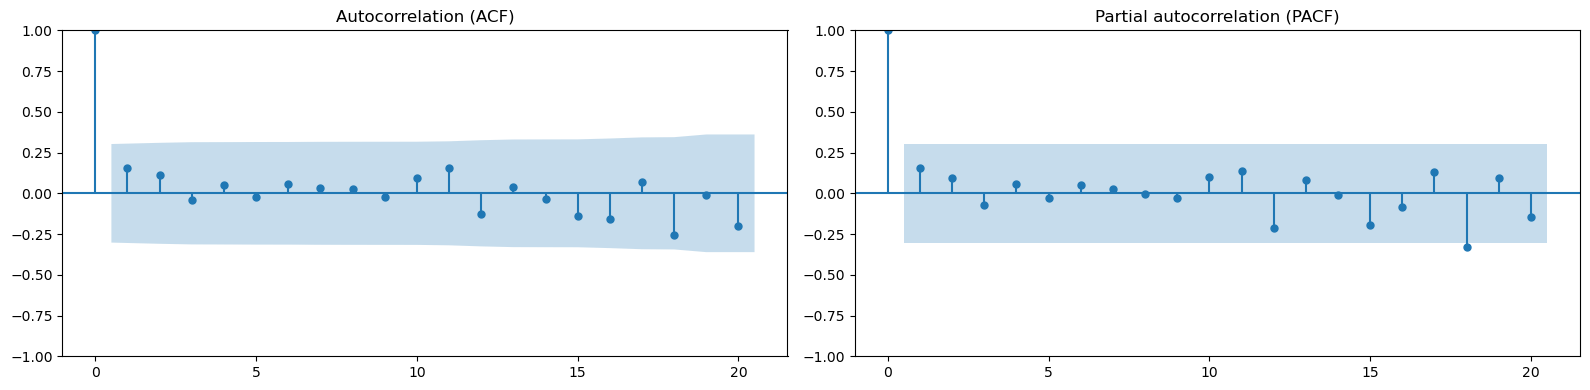

/opt/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported ind

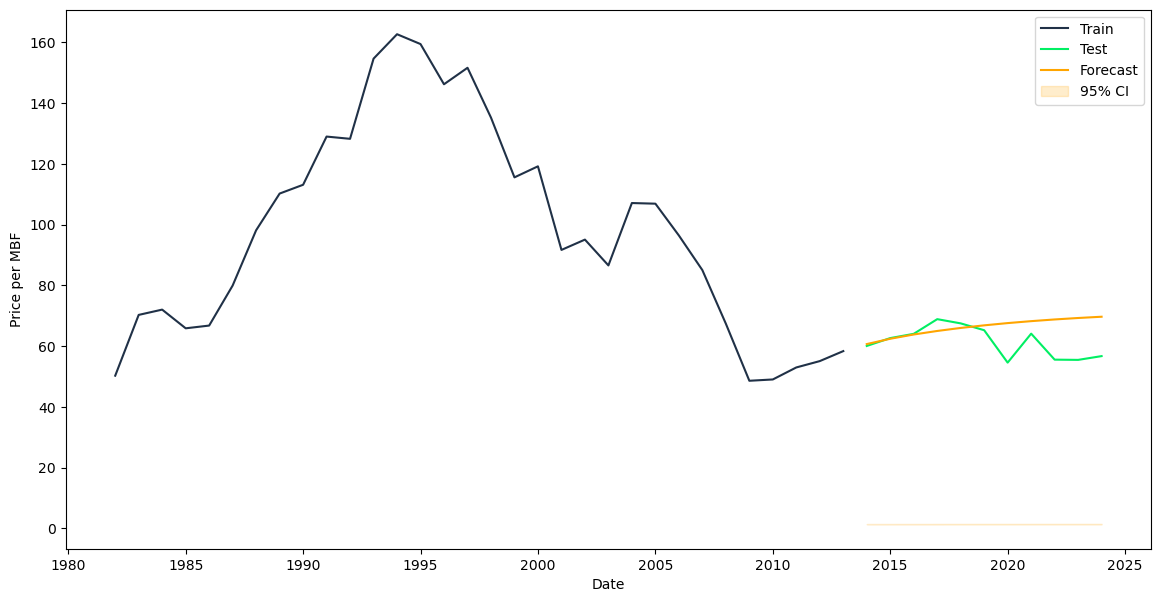

RMSE: 8.1968
                               SARIMAX Results                                
Dep. Variable:                 BoxCox   No. Observations:                   32
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 107.544
Date:                Sat, 05 Apr 2025   AIC                           -207.087
Time:                        10:02:08   BIC                           -201.224
Sample:                             0   HQIC                          -205.144
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4579      0.016     88.760      0.000       1.426       1.490
ar.L1          1.2989      0.186      6.987      0.000       0.935       1.663
ar.L2         -0.3791      0.176     -2

In [19]:
arimaDf = pd.read_csv('Data/Annual_Timber_Data.csv', parse_dates=['Fiscal Year'])
arimaDf = arimaDf[['Fiscal Year', 'Price_per_MBF_Harvested']]
# arimaDf = arimaDf[arimaDf['Fiscal Year']  > pd.Timestamp('1944-01-01')]
arimaDf = arimaDf[arimaDf['Fiscal Year']  > pd.Timestamp('1981-01-01')]
arimaDf['BoxCox'], lam = boxcox(arimaDf['Price_per_MBF_Harvested'])
arimaDf['log'] = np.log(arimaDf['Price_per_MBF_Harvested'])
arimaDf['lag1'] = arimaDf['Price_per_MBF_Harvested'].shift(1)
arimaDf['roll5'] = arimaDf['Price_per_MBF_Harvested'].rolling(window=5).mean()

result = adfuller(arimaDf['BoxCox'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
# Not stationary, need to check the difference

arimaDf['valueDiff'] = arimaDf['BoxCox'].diff()
result = adfuller(arimaDf['valueDiff'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
# Difference is stationary

sns.lineplot(arimaDf, x='Fiscal Year', y='valueDiff', label='ValueDiff')
#sns.lineplot(arimaDf, x='Fiscal Year', y='log', label='Log')

# Now we will need to determine autocorrelation with ACF
fig, axes = plt.subplots(1,2, figsize=(16,4))
plot_acf(arimaDf['valueDiff'].dropna(), lags = 20, ax=axes[0])
axes[0].set_title('Autocorrelation (ACF)')

plot_pacf(arimaDf['valueDiff'].dropna(), lags = 20, ax=axes[1])
axes[1].set_title('Partial autocorrelation (PACF)')
plt.tight_layout()
plt.show()

train = arimaDf[arimaDf['Fiscal Year'] < pd.Timestamp('2014-01-01')]
test = arimaDf[arimaDf['Fiscal Year'] >= pd.Timestamp('2014-01-01')]

model = ARIMA(train['BoxCox'], order=(2,0,0))
model_fit = model.fit()
# Boxcox forecast
boxcox_forecasts = model_fit.get_forecast(len(test))
forecast_values = boxcox_forecasts.predicted_mean
forecasts = inv_boxcox(forecast_values, lam)
conf_int = boxcox_forecasts.conf_int(alpha=0.05)
ci_lower = inv_boxcox(conf_int.iloc[:, 0], lam)
ci_upper = inv_boxcox(conf_int.iloc[:, 1], lam)
ci_lower = np.clip(ci_lower, a_min=0, a_max=None)
ci_upper = np.clip(ci_upper, a_min=0, a_max=None) 

# Forecast
#forecast = model_fit.get_forecast(steps=len(test))
#forecast_mean = forecast.predicted_mean
#forecast_mean = np.exp(forecast_mean)
#conf_int = forecast.conf_int(alpha=0.05)  # 95% CI
#conf_int = np.exp(conf_int)

# Ensure forecast index matches test index
#forecast.index = test['Fiscal Year'].values
#conf_int.index = test['Fiscal Year'].values

plt.figure(figsize=(14,7))
plt.plot(train['Fiscal Year'], train['Price_per_MBF_Harvested'], label='Train', color='#203147')
plt.plot(test['Fiscal Year'], test['Price_per_MBF_Harvested'], label='Test', color='#01ef63')
plt.plot(test['Fiscal Year'], forecasts, label='Forecast', color='orange')
plt.fill_between(test['Fiscal Year'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2, label="95% CI")
plt.xlabel('Date')
plt.ylabel('Price per MBF')
plt.legend()
plt.show()

test_MBF = test["Price_per_MBF_Harvested"][:len(forecasts)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_MBF, forecasts))
print(f"RMSE: {rmse:.4f}")

print(model_fit.summary())


In [16]:
print(conf_int.head())
from pmdarima import auto_arima

auto_model = auto_arima(train['BoxCox'], seasonal=False, trace=True, stepwise=True)
print(auto_model.summary())

            lower BoxCox  upper BoxCox
2014-01-01     48.024918     75.844582
2015-01-01     42.349753     91.379625
2016-01-01     38.989876    105.711472
2017-01-01     36.555445    120.406549
2018-01-01     34.639811    136.085246


/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-195.162, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=117.453, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-192.465, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-194.281, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-192.933, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-198.586, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-206.189, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-176.670, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-204.939, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-204.917, Time=0.03 sec


/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-205.147, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-151.409, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-192.581, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-206.943, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-205.076, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-203.153, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.013 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 107.471
Date:                Sat, 05 Apr 2025   AIC                           -206.943
Time:                        09:57:28   BIC                           -201.080
Sample:                             0   HQIC                          -204.999
                                 - 32                

/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/DS/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

-39.374 1,1,0


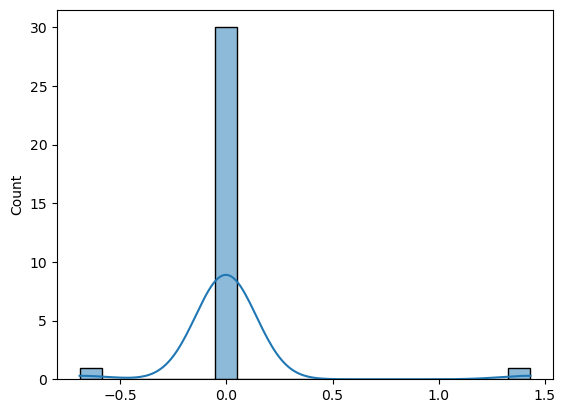

In [13]:
# Let's check those residuals!
residuals = model_fit.resid
plt.figure()
sns.histplot(residuals, bins=20, kde=True)
plt.show()

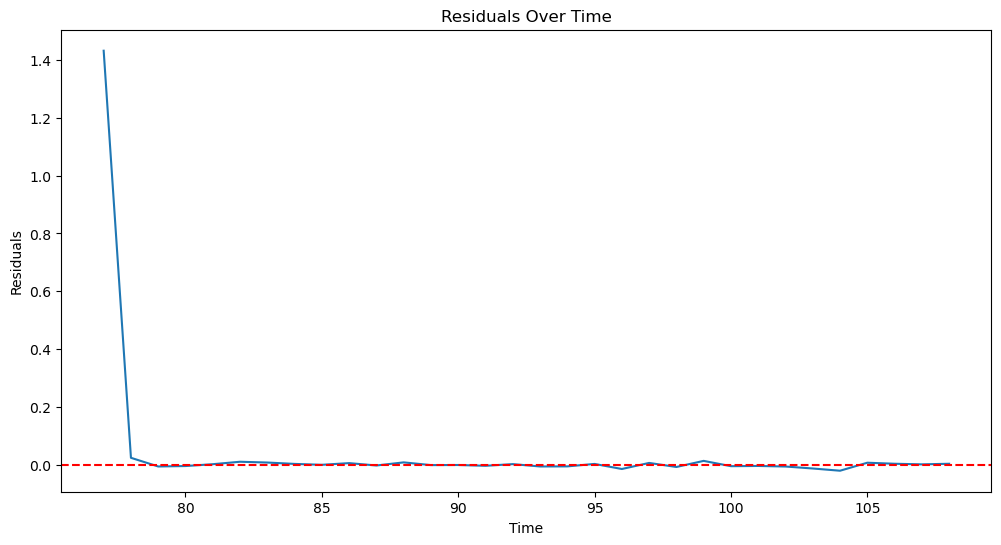

In [32]:
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

In [21]:
arimaDf

,Fiscal Year,Number_of_Sales,Volume_MBF_Sold,Value_Sold,Price_per_MBF_Solf,Volume_MBF_Harvested,Value_Harvested,Price_per_MBF_Harvested
0,1905,NaN,NaN,NaN,NaN,68475,85597,1.25
1,1906,NaN,NaN,NaN,NaN,138665,203333,1.47
2,1907,NaN,NaN,NaN,NaN,194872,337952,1.73
3,1908,NaN,NaN,NaN,NaN,392792,794252,2.02
4,1909,NaN,NaN,NaN,NaN,352434,677784,1.92
...,...,...,...,...,...,...,...,...
115,2020,152654.0,3218523.0,182935343.0,56.84,2550013,139145424,54.57
116,2021,87120.0,2844806.0,197876974.0,69.56,2377642,152405521,64.10
117,2022,89224.0,2939117.0,186345922.0,63.40,2559778,142191266,55.55
118,2023,113577.0,3083744.0,155360180.0,50.38,2939816,163060234,55.47


<Axes: xlabel='Fiscal Year', ylabel='Price_per_MBF_Harvested'>

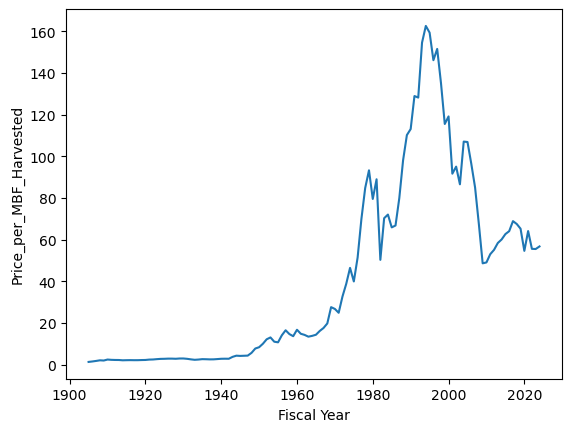

In [22]:
arimaDf = pd.read_csv('Data/Annual_Timber_Data.csv')
sns.lineplot(arimaDf, x='Fiscal Year', y='Price_per_MBF_Harvested')